# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 20000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (20000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(19354, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

96.77

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(19354, 10)


1    16339
0     3015
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
I received this box with great anticipation since they don't sell these on the west coast. I got the package, opened the box and was EXTREMELY disappointed. The cookies looked like a gorilla shook the box to death and left most of the box filled with crumbs. AND THERE WAS A RODENT SIZED HOLE ON THE SIDE OF THE BOX!!!!!!!! So, needless to say I will not NOT be reordering these again.
I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.
I was always a fan of Dave's, so I bought this at a local store to try Blair's and I'm glad I did.  The jalepeno saus

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
I received this box with great anticipation since they don't sell these on the west coast. I got the package, opened the box and was EXTREMELY disappointed. The cookies looked like a gorilla shook the box to death and left most of the box filled with crumbs. AND THERE WAS A RODENT SIZED HOLE ON THE SIDE OF THE BOX!!!!!!!! So, needless to say I will not NOT be reordering these again.
I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.
I was always a fan of Dave's, so I bought this at a local store to try Blair's and I'm glad I did.  The jalepeno saus

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I have two cats My big boy has eaten these and never had a problem as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months My girl cat throws up every time she eats this particular flavor Since I treat them equally these are no longer purchased I hate to see my girl sick so I just recommend you watch your cats after you give them these treats If not a problem carry on 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents
from bs4 import BeautifulSoup

from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 19354/19354 [00:05<00:00, 3518.43it/s]


In [23]:
preprocessed_reviews[1500]

'two cats big boy eaten never problem matter fact never vomited hair ball since adopted months girl cat throws every time eats particular flavor since treat equally no longer purchased hate see girl sick recommend watch cats give treats not problem carry'

## [4.4] Word2Vec

In [24]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need
def w2v_fit(preprocessed_reviews):
    i=0
    list_of_sentance=[]
    for sentance in preprocessed_reviews:
        list_of_sentance.append(sentance.split())

    is_your_ram_gt_16g=False
    want_to_use_google_w2v = False
    want_to_train_w2v = True

    if want_to_train_w2v:
        # min_count = 5 considers only words that occured atleast 5 times
        w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
        print(w2v_model.wv.most_similar('great'))
        print('='*50)
        print(w2v_model.wv.most_similar('worst'))

    elif want_to_use_google_w2v and is_your_ram_gt_16g:
        if os.path.isfile('GoogleNews-vectors-negative300.bin'):
            w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
            print(w2v_model.wv.most_similar('great'))
            print(w2v_model.wv.most_similar('worst'))
        else:
            print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
    return w2v_model

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [25]:
# average Word2Vec
# compute average word2vec for each review.
def avg_w2v_transform(w2v_model,list_of_sentence):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    #w2v_model = word2Vec(list_of_sentence)
    w2v_words = list(w2v_model.wv.vocab)
    for sent in tqdm(list_of_sentence): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        word_len = 0;
        for word in sent.split(): # for each word in a review/sentence
            if word in w2v_words:
                word_len += 1
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vec = sent_vec.tolist()
        sent_vec.append(word_len) 
        sent_vectors.append(sent_vec)
    return np.array(sent_vectors)

#### [4.4.1.2] TFIDF weighted W2v

In [26]:
def tf_idf_transform(model,w_model,list_of_sentence):
    # TF-IDF weighted Word2Vec
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    w2v_words = list(w_model.wv.vocab)
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentence): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent.split(): # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [31]:
# Please write all the code with proper documentation

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
#from sklearn.model_selection import cross_val_score
#from sklearn import cross_validation
from scipy import sparse


X_1, X_test, y_1, y_test = train_test_split(preprocessed_reviews, final['Score'], test_size=0.33, random_state=0)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.33)


#function to return length of review
def review_len(review):
    reviews_len =[]
    for sent in review:
        reviews_len.append(len(sent.split()))
    return np.array(reviews_len)

print(y_test.value_counts())

count_vect = CountVectorizer(ngram_range=(1,2))
#count_vect = CountVectorizer(ngram_range=(1,2)) 
count_vect.fit(X_tr)

##--- new feature - Corresponding Review length was added to the test, train and cv vectors seperately

test_vect = count_vect.transform(X_test)
#len_arr = review_len(X_test)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#test_vect = sparse.hstack((test_vect,len_arr[:,None])).A

cv_vect = count_vect.transform(X_cv)
#len_arr = review_len(X_cv)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#cv_vect = sparse.hstack((cv_vect,len_arr[:,None])).A

train_vect = count_vect.transform(X_tr)
#len_arr = review_len(X_tr)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#train_vect = sparse.hstack((train_vect,len_arr[:,None])).A

1    5409
0     978
Name: Score, dtype: int64


In [33]:
from sklearn.linear_model import LogisticRegression


train_auc = []
cv_auc = []
c_values = [0.0001,0.001,0.01,0.1,1,10,100]
for i in tqdm(c_values):
    lr = LogisticRegression(C = i, penalty='l1')
    lr.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = lr.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = lr.predict_proba(train_vect)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))

  0%|          | 0/7 [00:00<?, ?it/s]


ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

In [ ]:

plt.plot(np.log10(c_values), train_auc, label='Train AUC')
plt.plot(np.log10(c_values), cv_auc, label='CV AUC')
plt.legend()
plt.show()  
best_c = c_values[cv_auc.index(max(cv_auc))]
print("Best c-Value", c_values[cv_auc.index(max(cv_auc))])

In [ ]:
from sklearn.linear_model import LogisticRegression


best_lr = LogisticRegression(C = best_c, penalty='l1')
best_lr.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_lr.predict_proba(train_vect)
train_pred = train_pred[:,1]
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_lr.predict_proba(test_vect)
test_pred = test_pred[:,1]
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)
auc_bow_l1 = auc(test_fpr,test_tpr)
print("test_auc",auc_bow_l1)

plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
test_pred_class = best_lr.predict(test_vect)
print("Confusion matrix \n", confusion_matrix(y_test,test_pred_class))
accuracy_bow_l1 = best_lr.score(test_vect, y_test)
print("Test accuracy : ",accuracy_bow_l1)

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [ ]:
# Please write all the code with proper documentation

w = best_lr.coef_
non_zero_w = np.count_nonzero(w)

print("Total no.of weight W: ", w.size)
print("No.of weights W that became 0 : ", w.size-non_zero_w)



### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [35]:
from sklearn import preprocessing


test_vect=preprocessing.normalize(test_vect)
cv_vect=preprocessing.normalize(cv_vect)
train_vect=preprocessing.normalize(train_vect)

from sklearn.linear_model import LogisticRegression


train_auc = []
cv_auc = []
c_values = [0.0001,0.001,0.01,0.1,1,10,100]
for i in tqdm(c_values):
    lr = LogisticRegression(C = i, penalty='l2')
    lr.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = lr.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = lr.predict_proba(train_vect)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))

 71%|███████▏  | 5/7 [00:03<00:01,  1.33it/s]/Users/ravishankar/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 86%|████████▌ | 6/7 [00:05<00:01,  1.19s/it]/Users/ravishankar/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the do

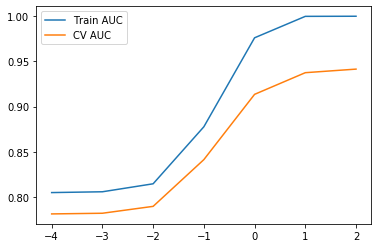

Best c-Value 100


In [36]:

plt.plot(np.log10(c_values), train_auc, label='Train AUC')
plt.plot(np.log10(c_values), cv_auc, label='CV AUC')
plt.legend()
plt.show()  
best_c = c_values[cv_auc.index(max(cv_auc))]
print("Best c-Value", c_values[cv_auc.index(max(cv_auc))])

test_auc 0.940782725601994


/Users/ravishankar/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


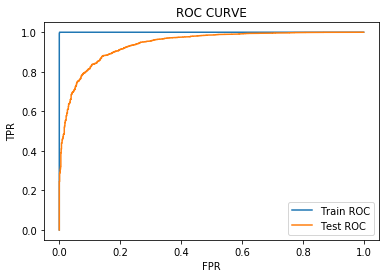

In [37]:
best_lr = LogisticRegression(C = best_c, penalty='l2')
best_lr.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_lr.predict_proba(train_vect)
train_pred = train_pred[:,1]
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_lr.predict_proba(test_vect)
test_pred = test_pred[:,1]
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)
auc_bow_l2 = auc(test_fpr,test_tpr)
print("test_auc",auc_bow_l2)

plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import confusion_matrix
test_pred_class = best_lr.predict(test_vect)
print("Confusion matrix \n", confusion_matrix(y_test,test_pred_class))
accuracy_bow_l2 = best_lr.score(test_vect, y_test)
print("Test accuracy : ",accuracy_bow_l2)

Confusion matrix 
 [[ 596  382]
 [ 138 5271]]
Test accuracy :  0.918584625019571


#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [39]:
original_w = best_lr.coef_
print(original_w.shape)

(1, 230799)


In [40]:
error = np.random.normal(loc=0.0, scale=0.000001,size=train_vect.shape)
train_vect= train_vect + error
#error = 0.5*np.random.randn(train_vect.shape[0],train_vect.shape[1])
print(error)

[[ 2.10513546e-07  7.29980819e-07 -5.65644967e-07 ... -7.28913461e-07
  -1.19471493e-06  3.20902478e-09]
 [ 5.42266150e-07  2.87602314e-07 -1.55665131e-06 ...  2.41254313e-07
   7.13506165e-07 -6.22394788e-07]
 [ 1.95840703e-06  2.92578547e-08  1.01025784e-06 ...  4.43035875e-07
  -1.34544199e-06  3.22405901e-07]
 ...
 [-6.94169493e-07  7.74758943e-07 -1.24463655e-07 ...  9.96836541e-07
   1.34964280e-06 -1.02028887e-06]
 [ 6.74235681e-07  7.73626272e-07  3.07009042e-07 ... -1.76692132e-07
   2.18796192e-07  1.57491837e-07]
 [ 9.32234838e-07  5.80689348e-07  5.02371190e-07 ... -1.18481064e-06
   5.65387541e-07  9.24688908e-07]]


In [41]:
best_lr = LogisticRegression(C = best_c, penalty='l2')
best_lr.fit(train_vect, y_tr)

/Users/ravishankar/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
new_w = best_lr.coef_
print(new_w.shape)

(1, 230799)


In [43]:
original_w = original_w + 0.000001
new_w = new_w + 0.000001

In [ ]:
change = original_w - new_w
change = change/original_w
change = abs(change * 100)

print(change)

In [ ]:

per = []
for i in range(1,100):
    per.append(np.percentile(change, i))
print(per)

In [ ]:
perc = np.arange(1,100)
plt.plot(perc,per, label="Train ROC")
plt.xlabel("percentile")
plt.ylabel("change value")
plt.title("percentile change")
plt.legend()
plt.show()

In [ ]:
#https://stackoverflow.com/questions/7270321/finding-the-index-of-elements-based-on-a-condition-using-python-list-comprehensi

collinear_w = np.where(change > 0.2)[1]
print(collinear_w)
features = count_vect.get_feature_names()
#https://stackoverflow.com/questions/50997928/typeerror-only-integer-scalar-arrays-can-be-converted-to-a-scalar-index-with-1d
collinear_features = np.array(features)[collinear_w]
print("Collinear features : ",collinear_features)

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [ ]:
# Getting feature names
features = count_vect.get_feature_names()
features.append("review_length")

#Getting weights of feature names
w_coeff = pd.DataFrame(best_lr.coef_,columns=features)

w_coeff = w_coeff.T

print("Top 10 Positive features \n",w_coeff[0].sort_values(ascending = False)[0:10])

#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [ ]:


print("Top 10 Negative features \n",w_coeff[0].sort_values(ascending = True)[0:10])

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [ ]:
# Please write all the code with proper documentation

from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from scipy import sparse


X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.33, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.33)


#function to return length of review
def review_len(review):
    reviews_len =[]
    for sent in review:
        reviews_len.append(len(sent.split()))
    return np.array(reviews_len)

print(y_test.value_counts())

count_vect = TfidfVectorizer(ngram_range=(1,2))
#count_vect = CountVectorizer(ngram_range=(1,2)) 
count_vect.fit(X_tr)

##--- new feature - Corresponding Review length was added to the test, train and cv vectors seperately

test_vect = count_vect.transform(X_test)
#len_arr = review_len(X_test)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#test_vect = sparse.hstack((test_vect,len_arr[:,None])).A

cv_vect = count_vect.transform(X_cv)
#len_arr = review_len(X_cv)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#cv_vect = sparse.hstack((cv_vect,len_arr[:,None])).A

train_vect = count_vect.transform(X_tr)
#len_arr = review_len(X_tr)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#train_vect = sparse.hstack((train_vect,len_arr[:,None])).A

In [ ]:
from sklearn.linear_model import LogisticRegression


train_auc = []
cv_auc = []
c_values = [0.0001,0.001,0.01,0.1,1,10,100]
for i in tqdm(c_values):
    lr = LogisticRegression(C = i, penalty='l1')
    lr.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = lr.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = lr.predict_proba(train_vect)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))

In [ ]:

plt.plot(np.log10(c_values), train_auc, label='Train AUC')
plt.plot(np.log10(c_values), cv_auc, label='CV AUC')
plt.legend()
plt.show()  
best_c = c_values[cv_auc.index(max(cv_auc))]
print("Best c-Value", c_values[cv_auc.index(max(cv_auc))])

In [ ]:


best_lr = LogisticRegression(C = best_c, penalty='l1')
best_lr.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_lr.predict_proba(train_vect)
train_pred = train_pred[:,1]
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_lr.predict_proba(test_vect)
test_pred = test_pred[:,1]
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)
auc_td_l1 = auc(test_fpr,test_tpr)
print("test_auc",auc_td_l1)

plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
test_pred_class = best_lr.predict(test_vect)
print("Confusion matrix \n", confusion_matrix(y_test,test_pred_class))
accuracy_td_l1 = best_lr.score(test_vect, y_test)
print("Test accuracy : ",accuracy_td_l1)

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [ ]:
from sklearn.linear_model import LogisticRegression


train_auc = []
cv_auc = []
c_values = [0.0001,0.001,0.01,0.1,1,10,100]
for i in tqdm(c_values):
    lr = LogisticRegression(C = i, penalty='l2')
    lr.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = lr.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = lr.predict_proba(train_vect)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))

In [ ]:

plt.plot(np.log10(c_values), train_auc, label='Train AUC')
plt.plot(np.log10(c_values), cv_auc, label='CV AUC')
plt.legend()
plt.show()  
best_c = c_values[cv_auc.index(max(cv_auc))]
print("Best c-Value", c_values[cv_auc.index(max(cv_auc))])

In [ ]:


best_lr = LogisticRegression(C = best_c, penalty='l2')
best_lr.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_lr.predict_proba(train_vect)
train_pred = train_pred[:,1]
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_lr.predict_proba(test_vect)
test_pred = test_pred[:,1]
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)
auc_td_l2 = auc(test_fpr,test_tpr)
print("test_auc",auc_td_l2)

plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
test_pred_class = best_lr.predict(test_vect)
print("Confusion matrix \n", confusion_matrix(y_test,test_pred_class))
accuracy_td_l2 = best_lr.score(test_vect, y_test)
print("Test accuracy : ",accuracy_td_l2)

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [ ]:
# Getting feature names
features = count_vect.get_feature_names()
features.append("review_length")

#Getting log probabilities of feature names
w_coeff = pd.DataFrame(best_lr.coef_,columns=features)

w_coeff = w_coeff.T

print("Top 10 Positive features \n",w_coeff[0].sort_values(ascending = False)[0:10])

#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [ ]:


print("Top 10 Negative features \n",w_coeff[0].sort_values(ascending = True)[0:10])

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [ ]:
# Please write all the code with proper documentation

from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from scipy import sparse


X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.33, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.33)


#function to return length of review
def review_len(review):
    reviews_len =[]
    for sent in review:
        reviews_len.append(len(sent.split()))
    return np.array(reviews_len)

print(y_test.value_counts())

w2v_model = w2v_fit(X_tr)
#count_vect = CountVectorizer(ngram_range=(1,2)) 

##--- new feature - Corresponding Review length was added to the test, train and cv vectors seperately
test_vect = avg_w2v_transform(w2v_model,X_test)
#len_arr = review_len(X_test)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#print(test_vect.shape)
print(test_vect)
#test_vect = sparse.hstack((test_vect,len_arr[:,None])).A

cv_vect = avg_w2v_transform(w2v_model,X_cv)
#len_arr = review_len(X_cv)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#cv_vect = sparse.hstack((cv_vect,len_arr[:,None])).A

train_vect = avg_w2v_transform(w2v_model,X_tr)
#len_arr = review_len(X_tr)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#train_vect = sparse.hstack((train_vect,len_arr[:,None])).A

In [ ]:
from sklearn.linear_model import LogisticRegression


train_auc = []
cv_auc = []
c_values = [0.0001,0.001,0.01,0.1,1,10,100]
for i in tqdm(c_values):
    lr = LogisticRegression(C = i, penalty='l1')
    lr.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = lr.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = lr.predict_proba(train_vect)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))

In [ ]:

plt.plot(np.log10(c_values), train_auc, label='Train AUC')
plt.plot(np.log10(c_values), cv_auc, label='CV AUC')
plt.legend()
plt.show()  
best_c = c_values[cv_auc.index(max(cv_auc))]
print("Best c-Value", c_values[cv_auc.index(max(cv_auc))])

In [ ]:
from sklearn.linear_model import LogisticRegression


best_lr = LogisticRegression(C = best_c, penalty='l1')
best_lr.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_lr.predict_proba(train_vect)
train_pred = train_pred[:,1]
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_lr.predict_proba(test_vect)
test_pred = test_pred[:,1]
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)
auc_avgw2v_l1 = auc(test_fpr,test_tpr)
print("test_auc",auc_avgw2v_l1)

plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
test_pred_class = best_lr.predict(test_vect)
print("Confusion matrix \n", confusion_matrix(y_test,test_pred_class))
accuracy_avgw2v_l1 = best_lr.score(test_vect, y_test)
print("Test accuracy : ",accuracy_avgw2v_l1)

In [ ]:
# Please write all the code with proper documentation
print(test_vect[0])

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
from sklearn.linear_model import LogisticRegression


train_auc = []
cv_auc = []
c_values = [0.0001,0.001,0.01,0.1,1,10,100]
for i in tqdm(c_values):
    lr = LogisticRegression(C = i, penalty='l2')
    lr.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = lr.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = lr.predict_proba(train_vect)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))

In [ ]:

plt.plot(np.log10(c_values), train_auc, label='Train AUC')
plt.plot(np.log10(c_values), cv_auc, label='CV AUC')
plt.legend()
plt.show()  
best_c = c_values[cv_auc.index(max(cv_auc))]
print("Best c-Value", c_values[cv_auc.index(max(cv_auc))])

In [ ]:
from sklearn.linear_model import LogisticRegression


best_lr = LogisticRegression(C = best_c, penalty='l1')
best_lr.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_lr.predict_proba(train_vect)
train_pred = train_pred[:,1]
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_lr.predict_proba(test_vect)
test_pred = test_pred[:,1]
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)
auc_avgw2v_l2 = auc(test_fpr,test_tpr)
print("test_auc",auc_avgw2v_l2)

plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
test_pred_class = best_lr.predict(test_vect)
print("Confusion matrix \n", confusion_matrix(y_test,test_pred_class))
accuracy_avgw2v_l2 = best_lr.score(test_vect, y_test)
print("Test accuracy : ",accuracy_avgw2v_l2)

In [ ]:
# Please write all the code with proper documentation

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
# Please write all the code with proper documentation

from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from scipy import sparse


X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.33, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.33)


#function to return length of review
def review_len(review):
    reviews_len =[]
    for sent in review:
        reviews_len.append(len(sent.split()))
    return np.array(reviews_len)

print(y_test.value_counts())

model = TfidfVectorizer()
model.fit(X_tr)
w2v_model = w2v_fit(X_tr)

#count_vect = CountVectorizer(ngram_range=(1,2)) 

##--- new feature - Corresponding Review length was added to the test, train and cv vectors seperately
test_vect = tf_idf_transform(model,w2v_model,X_test)
#len_arr = review_len(X_test)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#test_vect = sparse.hstack((test_vect,len_arr[:,None])).A

cv_vect = tf_idf_transform(model,w2v_model,X_cv)
#len_arr = review_len(X_cv)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#cv_vect = sparse.hstack((cv_vect,len_arr[:,None])).A

train_vect = tf_idf_transform(model,w2v_model,X_tr)
#len_arr = review_len(X_tr)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#train_vect = sparse.hstack((train_vect,len_arr[:,None])).A

In [ ]:
from sklearn.linear_model import LogisticRegression


train_auc = []
cv_auc = []
c_values = [0.0001,0.001,0.01,0.1,1,10,100]
for i in tqdm(c_values):
    lr = LogisticRegression(C = i, penalty='l1')
    lr.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = lr.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = lr.predict_proba(train_vect)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))

In [ ]:

plt.plot(np.log10(c_values), train_auc, label='Train AUC')
plt.plot(np.log10(c_values), cv_auc, label='CV AUC')
plt.legend()
plt.show() 
best_c = c_values[cv_auc.index(max(cv_auc))]
print("Best c-Value", c_values[cv_auc.index(max(cv_auc))])

In [ ]:
from sklearn.linear_model import LogisticRegression


best_lr = LogisticRegression(C = best_c, penalty='l1')
best_lr.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_lr.predict_proba(train_vect)
train_pred = train_pred[:,1]
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_lr.predict_proba(test_vect)
test_pred = test_pred[:,1]
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)
auc_tdw2v_l1 = auc(test_fpr,test_tpr)
print("test_auc",auc_tdw2v_l1)

plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
test_pred_class = best_lr.predict(test_vect)
print("Confusion matrix \n", confusion_matrix(y_test,test_pred_class))
accuracy_tdw2v_l1 = best_lr.score(test_vect, y_test)
print("Test accuracy : ",accuracy_tdw2v_l1)

In [ ]:
# Please write all the code with proper documentation

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
from sklearn.linear_model import LogisticRegression


train_auc = []
cv_auc = []
c_values = [0.0001,0.001,0.01,0.1,1,10,100]
for i in tqdm(c_values):
    lr = LogisticRegression(C = i, penalty='l2')
    lr.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = lr.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = lr.predict_proba(train_vect)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))

In [ ]:

plt.plot(np.log10(c_values), train_auc, label='Train AUC')
plt.plot(np.log10(c_values), cv_auc, label='CV AUC')
plt.legend()
plt.show()  
best_c = c_values[cv_auc.index(max(cv_auc))]
print("Best c-Value", c_values[cv_auc.index(max(cv_auc))])

In [ ]:
from sklearn.linear_model import LogisticRegression


best_lr = LogisticRegression(C = best_c, penalty='l2')
best_lr.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_lr.predict_proba(train_vect)
train_pred = train_pred[:,1]
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_lr.predict_proba(test_vect)
test_pred = test_pred[:,1]
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)
auc_tdw2v_l2 = auc(test_fpr,test_tpr)
print("test_auc",auc_tdw2v_l2)

plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
test_pred_class = best_lr.predict(test_vect)
print("Confusion matrix \n", confusion_matrix(y_test,test_pred_class))
accuracy_tdw2v_l2 = best_lr.score(test_vect, y_test)
print("Test accuracy : ",accuracy_tdw2v_l2)

In [ ]:
# Please write all the code with proper documentation

# [6] Conclusions

In [ ]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable

## Prettytable reference: http://zetcode.com/python/prettytable/
x = PrettyTable(["Model", "Vectoriser", "Regularizer","Accuracy", "AUC"])

x.add_row(["Logistic_regression","BOW", "L1",accuracy_bow_l1*100, auc_bow_l1])
x.add_row(["Logistic_regression","BOW", "L2",accuracy_bow_l2*100, auc_bow_l2])
x.add_row(["Logistic_regression","TFIDF", "L1",accuracy_td_l1*100, auc_td_l1])
x.add_row(["Logistic_regression","TFIDF", "L2",accuracy_td_l2*100, auc_td_l2])
x.add_row(["Logistic_regression","AVG_W2V", "L1",accuracy_avgw2v_l1*100, auc_avgw2v_l1])
x.add_row(["Logistic_regression","AVG_W2V", "L2",accuracy_avgw2v_l2*100, auc_avgw2v_l2])
x.add_row(["Logistic_regression","TFIDF_W2V", "L1",accuracy_tdw2v_l1*100, auc_tdw2v_l1])
x.add_row(["Logistic_regression","TFIDF_W2V", "L2",accuracy_tdw2v_l2*100, auc_tdw2v_l2])

print(x.get_string())